In [22]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from rdkit import Chem

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [3]:
toxcast = pd.read_excel(raw_dir/'ToxCast41.xlsx')
toxcast.head()

,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,SMILES,QSAR_READY_SMILES
0,DTXSID3042423,DSSTox_Substance_Id,DTXSID3042423,Sucrose octaacetate,126-14-7,[H][C@]1(O[C@]2(COC(C)=O)O[C@H](COC(C)=O)[C@@H...,CC(=O)OCC1OC(COC(C)=O)(OC2OC(COC(C)=O)C(OC(C)=...
1,DTXSID3042477,DSSTox_Substance_Id,DTXSID3042477,Tolnaftate,2398-96-1,CN(C(=S)OC1=CC2=CC=CC=C2C=C1)C1=CC=CC(C)=C1,CN(C(=S)OC1=CC2=CC=CC=C2C=C1)C1=CC=CC(C)=C1
2,DTXSID3042500,DSSTox_Substance_Id,DTXSID3042500,Triphenyltin fluoride,379-52-2,F[Sn](C1=CC=CC=C1)(C1=CC=CC=C1)C1=CC=CC=C1,
3,DTXSID3042508,DSSTox_Substance_Id,DTXSID3042508,Uric acid,69-93-2,O=C1NC2=C(N1)C(=O)NC(=O)N2,[H]N1C2C(=NC1=O)N([H])C(=O)N([H])C2=O
4,DTXSID3042631,DSSTox_Substance_Id,DTXSID3042631,"(1R,3S)-3-(3,4-Dichlorophenyl)-N-methyl-2,3-di...",96850-13-4,Cl.CN[C@@H]1C[C@H](C2=CC=CC=C12)C1=CC=C(Cl)C(C...,CNC1CC(C2=CC=CC=C12)C1=CC(Cl)=C(Cl)C=C1


In [4]:
llna = pd.read_csv(raw_dir/'llna_cleaned.csv', index_col = [0])

In [5]:
import hashlib
from rdkit.Chem import rdFingerprintGenerator

def token_sentence(mol, radius):
    """
    Calculates ECFP (Morgan fingerprint) and returns identifiers of substructures as 'sentence' (string).
    Simulates the old behavior by hashing atom index and radius to produce globally unique identifiers.

    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
        Input molecule
    radius : float
        Fingerprint radius

    Returns
    -------
    list
        Alternating sentence
    """
    radii = list(range(int(radius) + 1))
    
    # Initialize the Morgan fingerprint generator and AdditionalOutput
    mfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=int(radius))
    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.AllocateBitInfoMap()
    
    # Generate the fingerprint and fill in AdditionalOutput
    _ = mfp_gen.GetFingerprint(mol, additionalOutput=ao)
    bit_info = ao.GetBitInfoMap()
    
    # Initialize atom-related data structure
    mol_atoms = [a.GetIdx() for a in mol.GetAtoms()]
    dict_atoms = {x: {r: None for r in radii} for x in mol_atoms}
    
    # Process the bit_info to populate atom-radius mappings
    for bit_id, atom_radius_pairs in bit_info.items():
        for atom_idx, radius_at in atom_radius_pairs:
            # Hash to simulate old-style identifiers
            hashed_id = hashlib.md5(f"{atom_idx}_{radius_at}".encode()).hexdigest()
            dict_atoms[atom_idx][radius_at] = hashed_id
    
    # Merge identifiers, alternating radius to sentence: atom 0 radius0, atom 0 radius 1, etc.
    identifiers_alt = []
    for atom in dict_atoms:  # Iterate over atoms
        for r in radii:  # Iterate over radii
            identifiers_alt.append(dict_atoms[atom][r])
    
    # Filter out None and convert identifiers to strings
    alternating_sentence = map(str, [x for x in identifiers_alt if x])
    
    return list(alternating_sentence)

In [45]:
from rdkit.Chem.SaltRemover import SaltRemover

In [62]:
remover = SaltRemover( defnData="[Cl,Br,Na,K,Ba,Hg,OH,Ca]" ) 

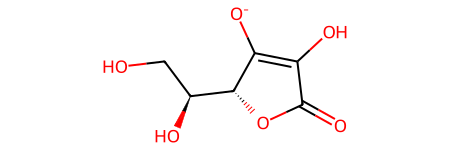

In [64]:
mol = Chem.MolFromSmiles('[Na+].OC[C@H](O)[C@H]1OC(=O)C(O)=C1[O-]')
res, deleted = remover.StripMolWithDeleted(mol)
res1 = remover.StripMol(mol,dontRemoveEverything=True)
res

In [92]:
toxcast = (toxcast
 .assign(smiles = lambda df: df['QSAR_READY_SMILES'].apply(lambda x: np.nan if x == ' '  else x))
 .dropna(subset = ['smiles'])
 
)

In [115]:
toxcast.to_csv(external_dir/'toxcast_cleaned.csv')

In [93]:
smiles_dict = {k:v for k,v in zip(toxcast['DTXSID'], toxcast['smiles'])}

In [94]:
llna_dict = {k:v for k,v in zip(llna['DTXSID'], llna['SMILES'])}

In [95]:
smi_mol = {k: Chem.MolFromSmiles(v) for k, v in smiles_dict.items() if v is not None}

[16:09:03] Explicit valence for atom # 5 N, 5, is greater than permitted


In [96]:
smi_mol = {k:v for k,v in smi_mol.items() if v is not None}

In [98]:
corpus_dict = {k: token_sentence(smile,1) for k,smile in smi_mol.items()}

In [99]:
len(corpus_dict['DTXSID3042423'])

94

In [100]:
from gensim.models import Word2Vec

# Train Word2Vec model
model = Word2Vec(sentences=list(corpus_dict.values()), vector_size=100, window=10, min_count=3, sg=1, workers=4)

# Save the trained model for future use
model.save("mol2vec.model")



In [101]:
import numpy as np

def get_molecule_embedding(smile, model, radius=1):
    """
    Computes a molecule embedding by averaging fragment embeddings.
    
    Args:
        smile (str): SMILES string of the molecule.
        model (gensim.models.Word2Vec): Trained Word2Vec model.
        radius (int): Radius for tokenization.
    
    Returns:
        np.ndarray: Molecule embedding.
    """
    tokens = token_sentence(Chem.MolFromSmiles(smile), radius)
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Example: Generate embedding for a molecule
molecule_embedding = get_molecule_embedding("CCO", model)
print(molecule_embedding.shape)  # (128,)


(100,)


In [102]:
embeddings = {}

for k, v in llna_dict.items():
     a = get_molecule_embedding(v, model)
     embeddings[k] = a

In [103]:
#embeddings['DTXSID1031626']

In [104]:
#embeddings['DTXSID7026235']

In [105]:
embeddings_df = pd.DataFrame(np.vstack((list(embeddings.values()))), index = embeddings.keys())

In [106]:
from scipy.spatial.distance import pdist, squareform

In [107]:
D_cos = pd.DataFrame(squareform(pdist(embeddings_df, 'cosine')), index = embeddings.keys(), columns = embeddings.keys())

<Axes: >

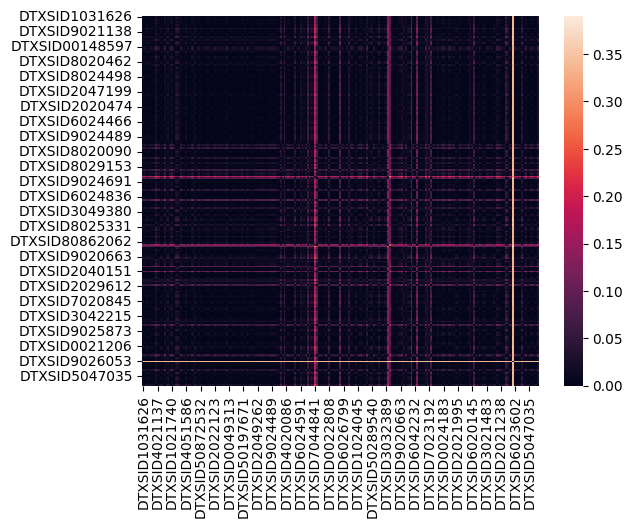

In [108]:
sns.heatmap(pd.DataFrame(squareform(pdist(embeddings_df, 'cosine')), index = embeddings.keys(), columns = embeddings.keys()))

In [109]:
rxn_domains = {k: group['DTXSID'].tolist() for k, group in llna.groupby('rxn') if len(group['DTXSID'].tolist()) >5}

In [110]:
D_cos.loc[['DTXSID4026684','DTXSID1024835','DTXSID4025587' ], ['DTXSID4026684','DTXSID1024835','DTXSID4025587' ]]

,DTXSID4026684,DTXSID1024835,DTXSID4025587
DTXSID4026684,0.000000,0.013258,0.009694
DTXSID1024835,0.013258,0.000000,0.001310
DTXSID4025587,0.009694,0.001310,0.000000


In [111]:
D_cos.loc[rxn_domains['SB'], rxn_domains['SB']].describe().loc['max'].max()

0.04708463769058302

In [112]:
D_cos.loc[rxn_domains['MA'], rxn_domains['MA']].describe().loc['max'].max()

0.21054876497312414

In [113]:
D_cos.loc[rxn_domains['Acyl'], rxn_domains['Acyl']].describe().loc['max'].max()

0.09451806888302361

In [114]:
D_cos.describe().loc['max'].max()

0.39037384354116555